In [1]:
import imageio.v3 as iio
from typing import Dict
import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
os.chdir("test_cases")
os.getcwd()

'/home/gmafrac/docs/learning/image_processing_course/enhancement-and-superresolution/test_cases'

In [3]:
def input(low_input: str, high_input: str):
    img_low = {}
    for i in range(0,4):
        img_low[i] = iio.imread(f"{low_input}{i}.png")

    img_high = iio.imread(f"{high_input}.png")
    
    return img_low, img_high

def rmse(img_high: np.array, img_high_calculated: np.array, print_error: bool = True):
    error = np.sqrt(((img_high - img_high_calculated)**2).sum()/img_high.size)
    
    if print is True:
        print(f"{error:.4f}") 
    return error


def intercalate(img1: np.array,img2: np.array):
    
    N, M = img1.shape
    img3 = np.empty( [N, M+M], dtype=img1.dtype)

    for row in range(0, img3.shape[0]):
        img3[row][0::2] = img1[row]
        img3[row][1::2] = img2[row]

    return img3
    
def superresolution(img_dict: Dict[int, np.array]):

    img1 = intercalate(img_dict[0],img_dict[2])
    img2 = intercalate(img_dict[1],img_dict[3])

    N, M = img1.shape
    img3 = np.empty([N+N, M], dtype=img1.dtype)
    img3[0::2] = img1
    img3[1::2] = img2
    
    return img3

def histogram(img: np.array, n_levels: int):
    
    hist = np.empty(n_levels, dtype=int)
    for level in range(n_levels):
        hist[level] = np.sum(img == level)
        
    return hist

def cumulative_histogram(
    n_levels: int = 256, 
    joint: bool = False, 
    img: np.array = None,
    img_dict: Dict[int, np.array] = None):
    
    N = M = n_levels
    if joint is True:
        hist = np.zeros(n_levels, dtype=int)
        for key in img_dict:
            hist = hist + histogram(img_dict[key], n_levels)
        resol = float(N*M*4)
    else:
        hist = histogram(img, n_levels)
        resol = float(N*M)
        
    histC = np.empty(n_levels, dtype=int)
    
    histC[0] = hist[0]
    for i in range(1, n_levels):
        histC[i] = hist[i] + histC[i-1]  
        
    return histC, resol

def histogram_equalization(
        img: np.array, 
        histC: np.array,  
        resol: int,
        n_levels: int = 256):

    new_img = np.empty([n_levels,n_levels], dtype = np.dtype('uint8'))
    for level in range(n_levels):     
        new_img[np.where(img == level)] = (n_levels-1)*histC[level]/resol
    return new_img

def single_image_cumulative_histogram(img_dict: Dict[int, np.array]):
    
    new_img_dict = {}
    for key in img_dict:
        histC, resol = cumulative_histogram(img=img_dict[key])
        new_img_dict[key] = histogram_equalization(img_dict[key], histC, resol)
        
    new_img = superresolution(new_img_dict)
    return new_img


def joint_cumulative_histogram(img_dict: Dict[int, np.array]):
    histC, resol = cumulative_histogram(img_dict=img_dict, joint=True)
    
    new_img_dict = {}
    for key in img_dict:
        new_img_dict[key] = histogram_equalization(img_dict[key], histC, resol)
        
    new_img = superresolution(new_img_dict)
    return new_img

def gamma_function(img: np.array, gamma: float):
    return 255 * (img/255)**(1/gamma)

def gamma_correction(img_dict: Dict[int, np.array], gamma: float):
    new_img_dict = {}
    for key in img_dict:
        new_img_dict[key] = gamma_function(img_dict[key], gamma)
    
    new_img = superresolution(new_img_dict)
    return new_img
        

In [16]:
def img_subplot(img, subplot, title = ""):
    plt.subplot(subplot)
    plt.imshow(img, cmap = "gray")
    plt.title(title)
    plt.axis("off")

def hist_subplot(img, subplot):
    
    plt.subplot(subplot)
    plt.bar(range(0,256), histogram(img_high, 256))
    plt.xlabel("Graylevel/Intensity")
    plt.ylabel("Frequency")    

In [5]:
img_low, img_high = input("01_low","01_high")

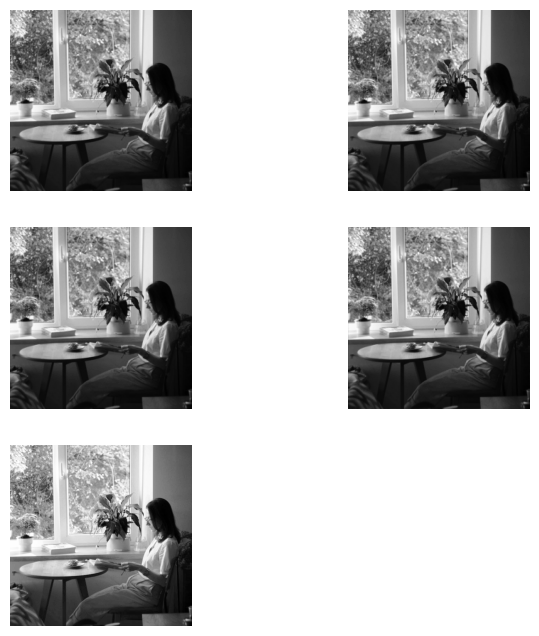

In [6]:
plt.figure(figsize=(8,8))

img_subplot(img_low[0], 321)
img_subplot(img_low[1], 322)
img_subplot(img_low[2], 323)
img_subplot(img_low[3], 324)
img_subplot(img_high, 325)

In [7]:
img_high_calculated = superresolution(img_low)

In [24]:
def test_all_cases(dict_img: Dict[int, np.array], img_high: np.array):
    img_case_0 = superresolution(dict_img) 
    img_case_1 = single_image_cumulative_histogram(dict_img)
    img_case_2 = joint_cumulative_histogram(dict_img)
    img_case_3 = gamma_correction(dict_img, 2)

    plt.figure(figsize=(8,8))
    img_subplot(img_case_0, 321, title=f"Case 0: {rmse(img_high, img_case_0, False):4f}")
    img_subplot(img_case_1, 322, title=f"Case 1: {rmse(img_high, img_case_1, False):4f}")
    img_subplot(img_case_2, 323, title=f"Case 2: {rmse(img_high, img_case_2, False):4f}")
    img_subplot(img_case_3, 324, title=f"Case 3: {rmse(img_high, img_case_3, False):4f} (Gamma = 2)")
    img_subplot(img_high, 325, title= "High Resolution")
    plt.show()

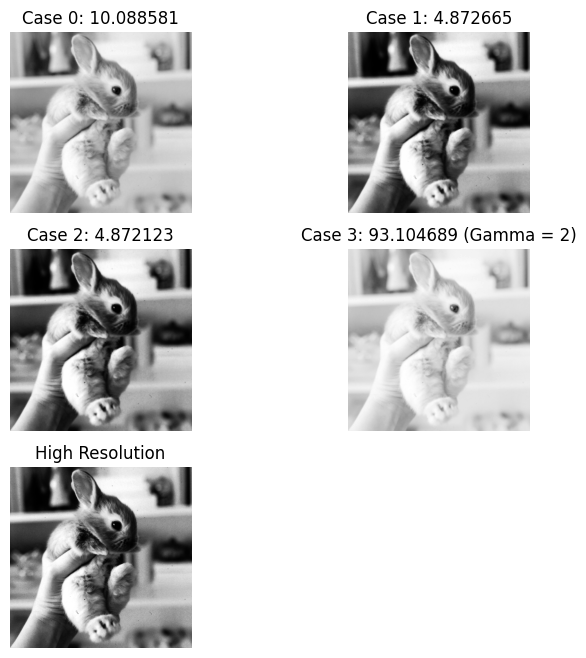

In [25]:
test_all_cases(img_low, img_high)

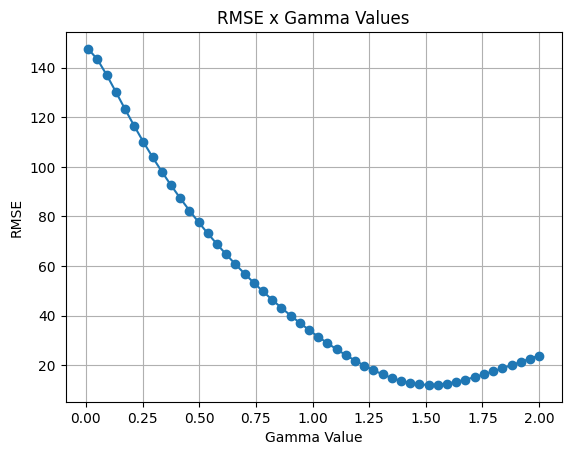

In [10]:
def plot_gamma_x_rmse(img_low: np.array, img_high: np.array):
    gamma_values = np.linspace(0.01, 2.0, 50)
    rmse_values = []

    for gamma in gamma_values:
        corrected_img_low = gamma_correction(img_low, gamma)
        rmse_val = rmse(img_high, corrected_img_low, print_error=False)
        rmse_values.append(rmse_val)
        
    plt.plot(gamma_values, rmse_values, marker='o')
    plt.title('RMSE x Gamma Values')
    plt.xlabel('Gamma Value')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

plot_gamma_x_rmse(img_low, img_high)

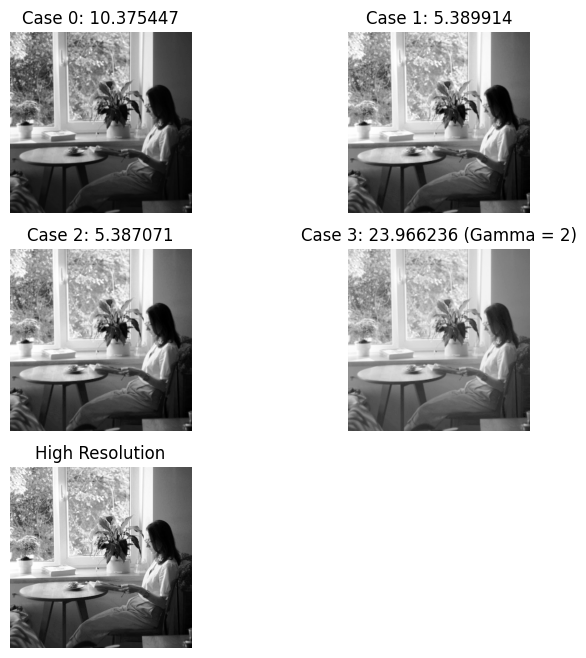

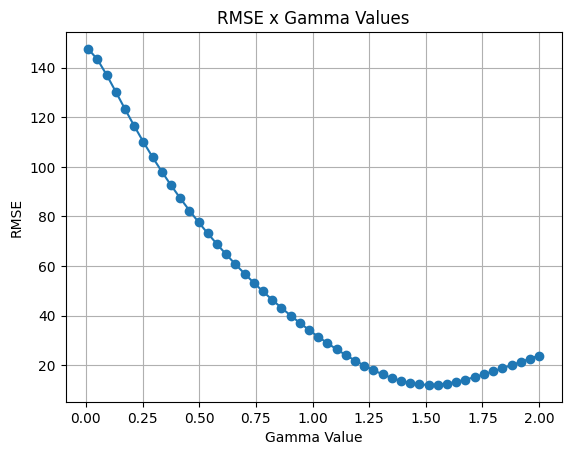

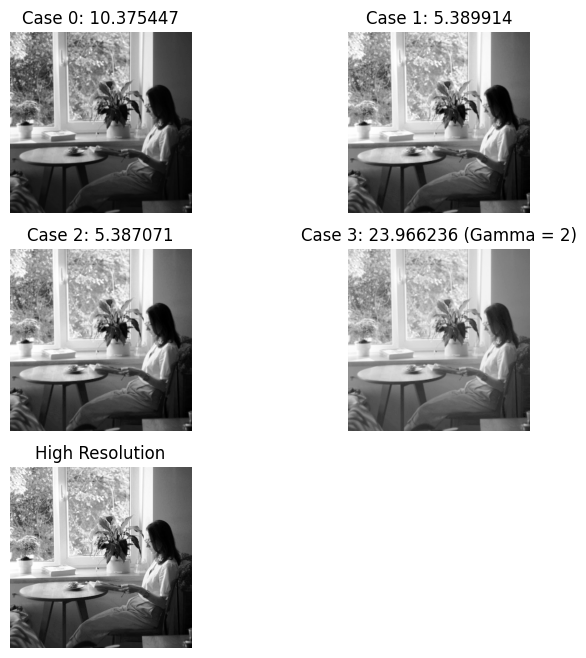

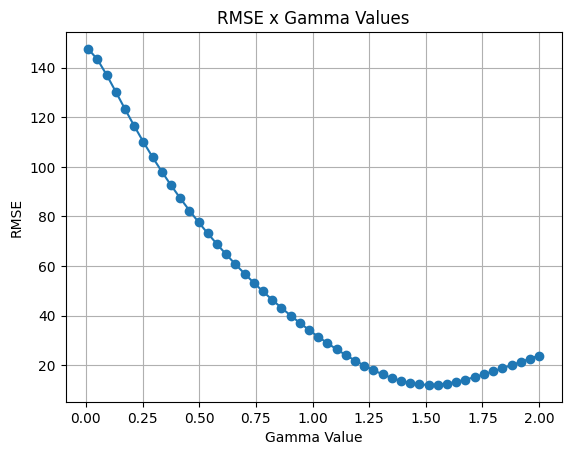

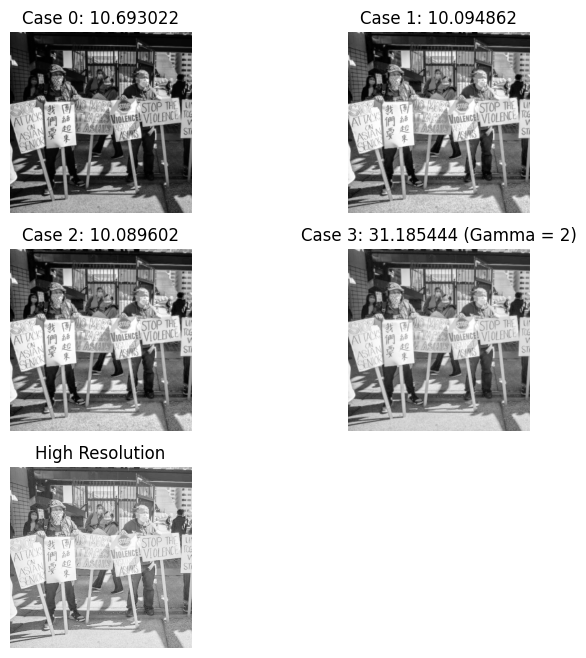

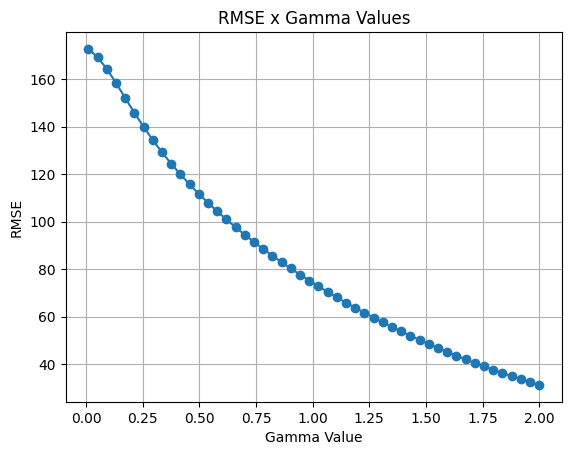

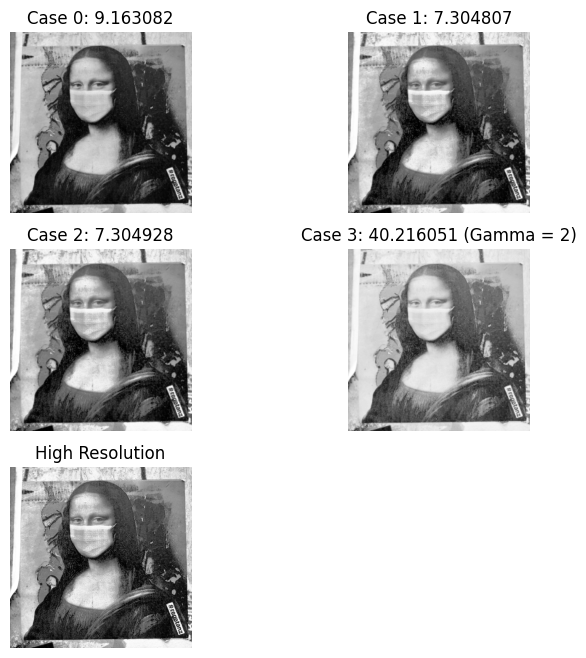

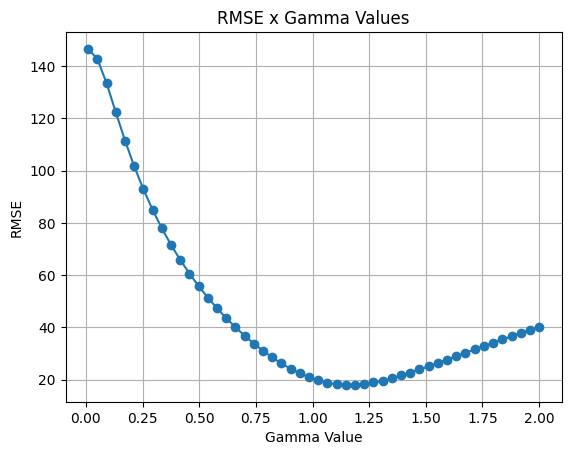

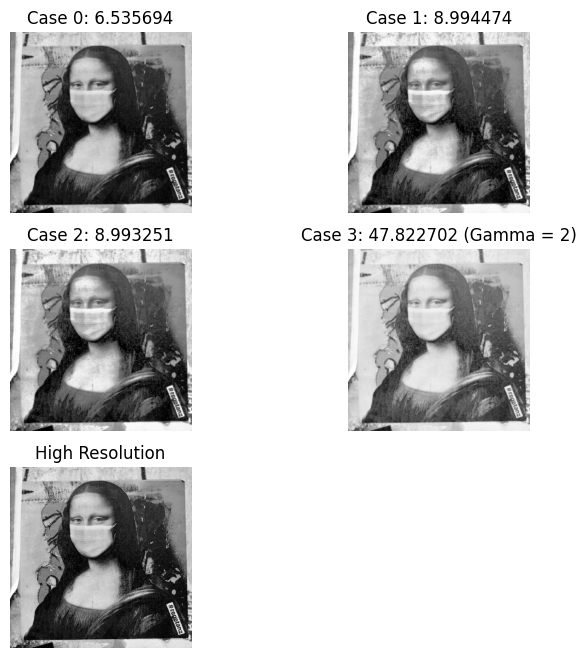

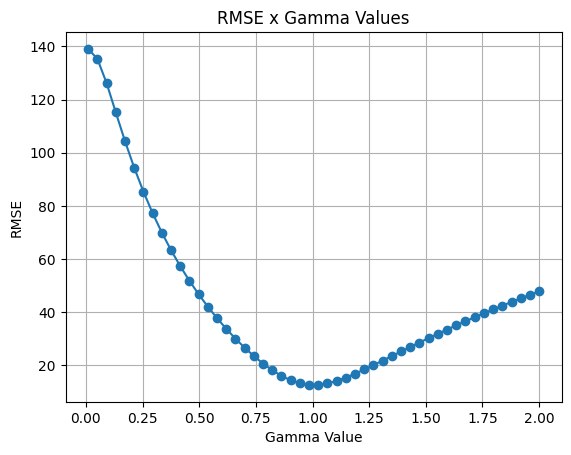

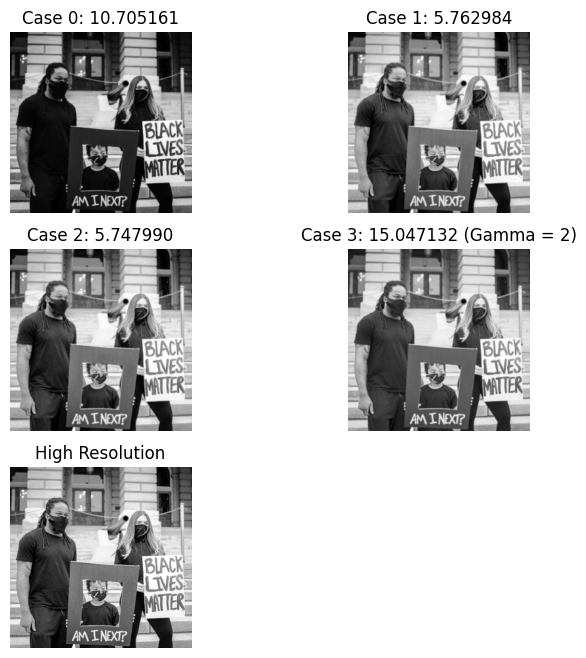

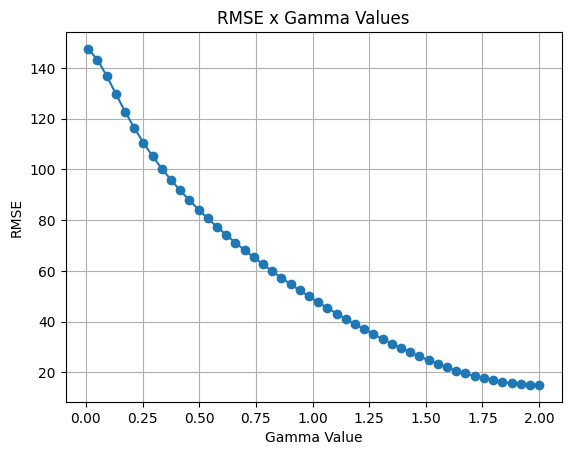

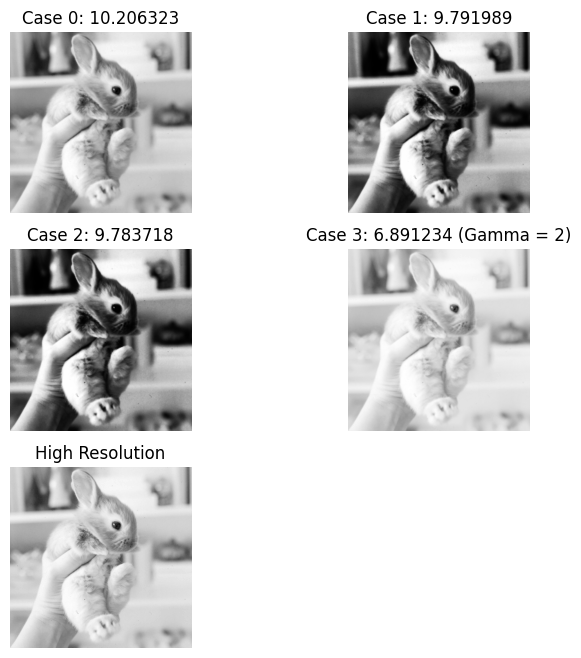

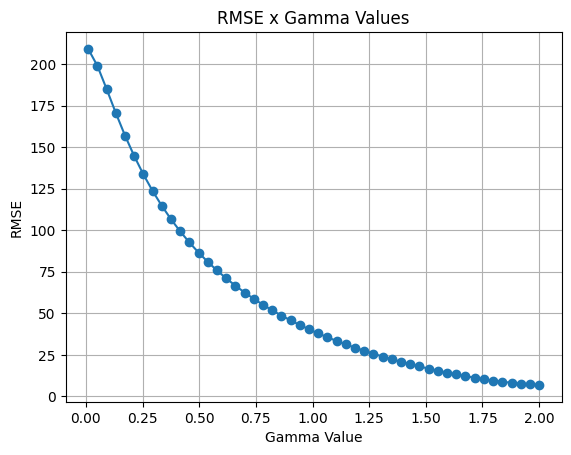

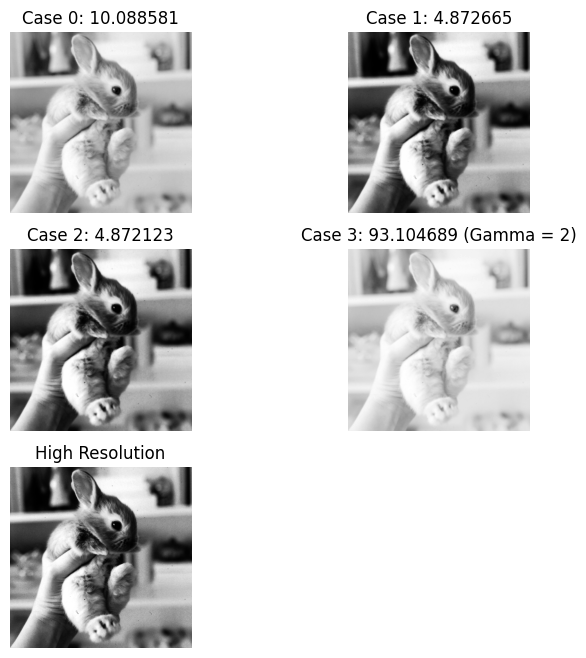

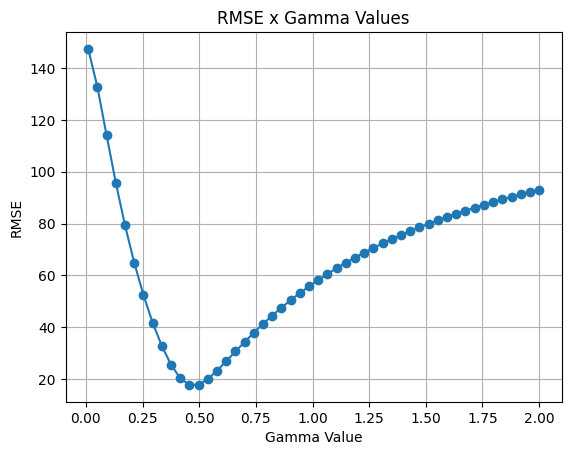

In [26]:
for i in range (1,9):
    img_low, img_high = input(f"0{i}_low", f"0{i}_high")
    test_all_cases(img_low, img_high)
    plot_gamma_x_rmse(img_low, img_high)